[[0.         0.         0.06939966 ... 0.02775986 0.         0.        ]
 [0.         0.         0.         ... 0.02565177 0.         0.        ]
 [0.1547877  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.03374737 0.02812281 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[4], [11], [12], [22], [35], [39], [48], [49], [53], [60], [56, 26, 25, 32, 27, 5, 17, 31, 1, 54, 6, 9, 57, 13, 41, 7, 19], [61, 2, 44, 59, 36, 8, 40, 20, 37, 14, 16, 38, 33, 43, 15, 24, 51, 55, 29, 45, 50, 18, 21, 34, 52, 28, 30, 42, 47, 0, 10, 3, 23], [46, 58]]
----------------------------Initial Community----------------------------------
Community 1: [4]
Community 2: [11]
Community 3: [12]
Community 4: [22]
Community 5: [35]
Community 6: [39]
Community 7: [48]
Community 8: [49]
Community 9: [53]
Community 10: [60]
Community 11: [56, 26, 25, 32, 

<ipython-input-2-6cb5814f8ac6>:327: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)


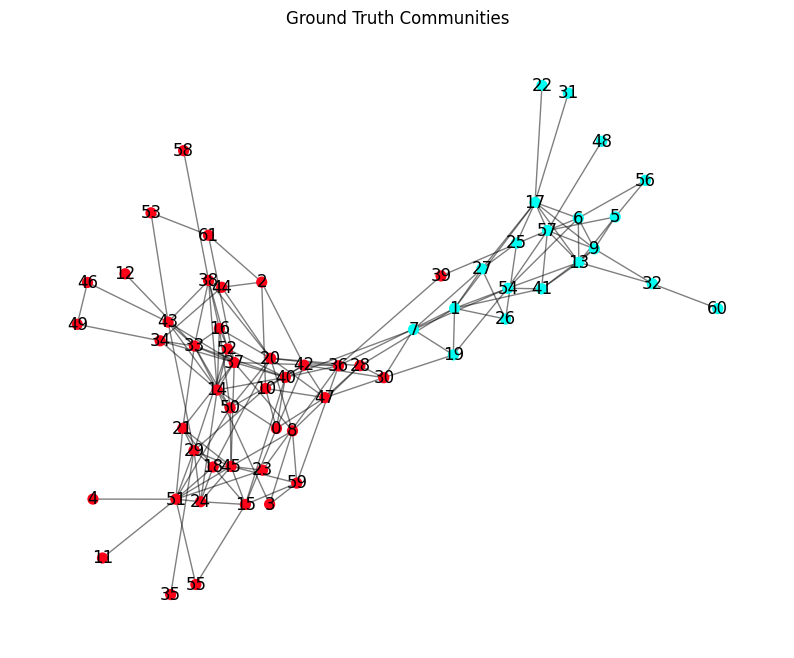

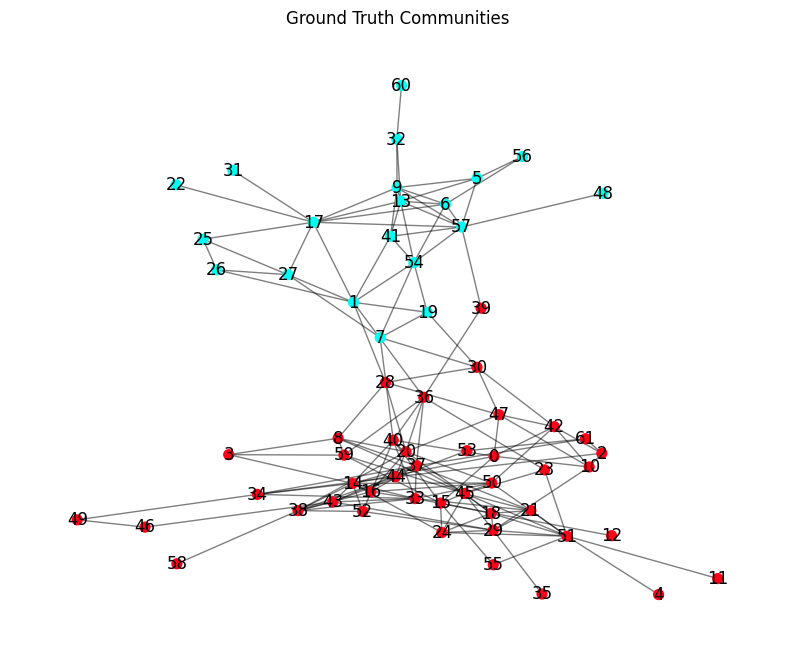

<ipython-input-2-6cb5814f8ac6>:350: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(communities)+1)


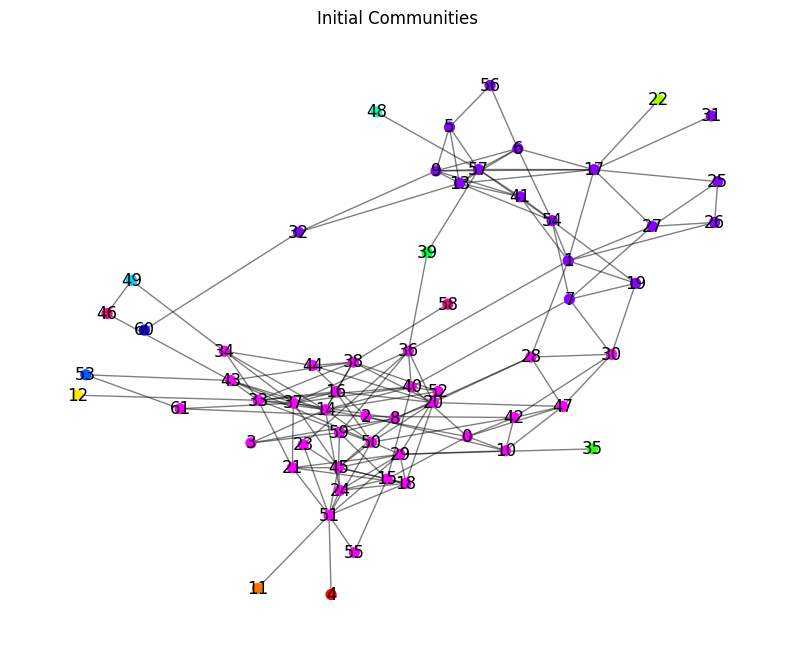

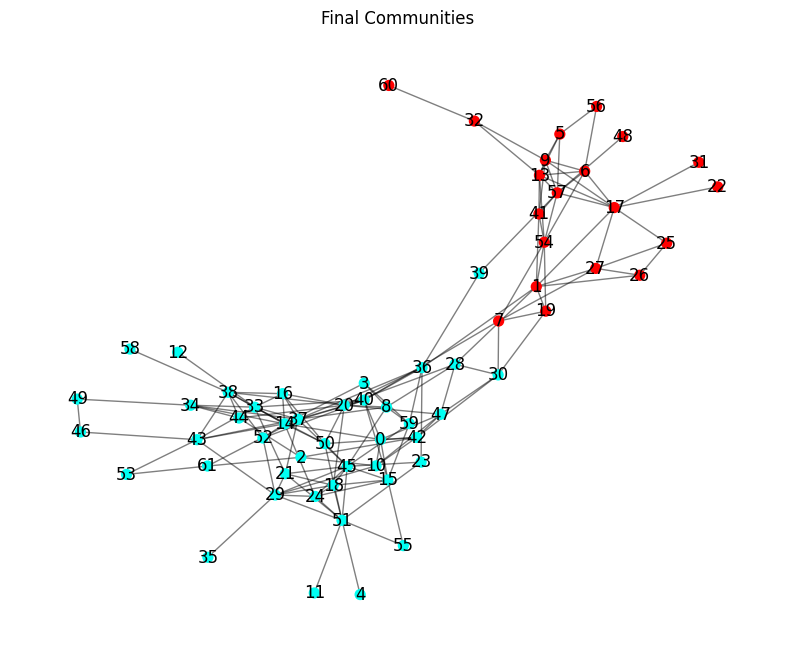

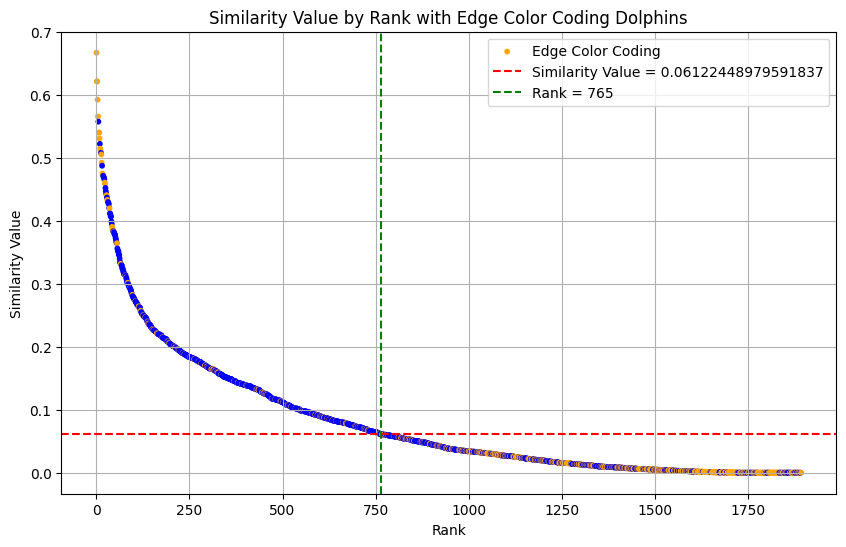

[(4, 51), (11, 51), (32, 60), (46, 49), (53, 61)]
Percentage of edges in G that are also in edges_in_G: 3.14%


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
import urllib.request
import io
import zipfile
import copy

def merge_small_communities(G, initial_communities, lambda_threshold=3):
    # Step 1: Classify communities based on size
    small_communities = [set(c) for c in initial_communities if len(c) < lambda_threshold]
    large_communities = [set(c) for c in initial_communities if len(c) >= lambda_threshold]

    # Initialize a list to store nodes from small communities without neighbors in large communities
    unassigned_nodes = []

    # For each small community, find the best large community to merge into
    for small_community in small_communities:
        best_total_similarity = 0
        best_large_community_index = None

        # Calculate total similarity of each small community node with nodes in each large community
        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for node in small_community:
                has_neighbor_in_large_community = any(neighbor in large_community for neighbor in G.neighbors(node))
                if has_neighbor_in_large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    for neighbor in G.neighbors(node):
                        if neighbor in large_community:
                            n_v = set(G.neighbors(neighbor)) | {neighbor}
                            intersection = len(n_u & n_v)
                            union = len(n_u | n_v)
                            similarity = float(intersection) / union if union != 0 else 0
                            total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # If no neighbors in large community, add the node to unassigned list
        if best_large_community_index is None:
            unassigned_nodes.extend(small_community)
        else:
            # Merge the small community into the best matching large community
            large_communities[best_large_community_index] = large_communities[best_large_community_index].union(small_community)

    # Reevaluate unassigned nodes with updated large communities
    for node in unassigned_nodes:
        best_total_similarity = 0
        best_large_community_index = None

        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for neighbor in G.neighbors(node):
                if neighbor in large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    n_v = set(G.neighbors(neighbor)) | {neighbor}
                    intersection = len(n_u & n_v)
                    union = len(n_u | n_v)
                    similarity = float(intersection) / union if union != 0 else 0
                    total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # Merge the unassigned node into the best matching large community
        if best_large_community_index is not None:
            large_communities[best_large_community_index].add(node)

    # Combine all communities after merging
    final_communities = large_communities + [list(c) for c in small_communities if len(c) >= lambda_threshold]

    return final_communities


def find_most_similar_node_pairs_iterative(similarity_matrix):
    current_similarity_matrix = copy.deepcopy(similarity_matrix)
    num_nodes = current_similarity_matrix.shape[0]

    # Initialize a dictionary to store results based on similarity values
    similar_pairs_dict = {}
    s = set()
    while (len(s) < num_nodes):
        # Find the indices of the maximum similarity value in the entire matrix
        i, j = np.unravel_index(np.argmax(current_similarity_matrix, axis=None), current_similarity_matrix.shape)
        similar_pair = (i, j)
        s.add(i)
        s.add(j)
        similar_value = current_similarity_matrix[i, j]

        # Exclude the current pair by setting its similarity to -inf
        current_similarity_matrix[i, j] = -np.inf

        # Append the result to the dictionary based on similarity value
        if similar_value not in similar_pairs_dict:
            similar_pairs_dict[similar_value] = []

        similar_pairs_dict[similar_value].append(similar_pair)

    # Print and return the results
    # for value, pairs in similar_pairs_dict.items():
    #     for idx, pair in enumerate(pairs):
    #          print(f"Similar Pair with Value {value}, Index {idx + 1}: {pair}")

    return similar_pairs_dict


def form_initial_communities(G, result_matrix, lambda_threshold=2, similarity_threshold=0.15):
    num_nodes = result_matrix.shape[0]
    communities = [[node] for node in range(num_nodes)]  # Initially, each node is in its own community
    edges_in_G = []  # List to hold edges present in G and set to zero
    edges_not_in_G = []  # List to hold edges not present in G and set to zero
    # Create a new similarity matrix with updated values
    updated_similarity_matrix = result_matrix.copy()
    zero_count = 0  # Counter for zero entries

    for i in range(num_nodes):
        for j in range(i+1,num_nodes):  # Consider upper triangular matrix to avoid repetition
            if result_matrix[i, j] < similarity_threshold:
                updated_similarity_matrix[i, j] = 0
                updated_similarity_matrix[j, i] = 0  # Symmetric update
                if G.has_edge(i, j) or G.has_edge(j, i):
                    edges_in_G.append((i, j))
                else:
                    edges_not_in_G.append((i, j))

    # Calculate the total number of node pairs
    # total_pairs = num_nodes * num_nodes
    # print(zero_count)

    # Calculate the percentage of node pairs assigned zero
    # zero_percentage = (zero_count / total_pairs) * 100

    # # Print the new similarity matrix
    # print("New Similarity Matrix:")
    # for row in updated_similarity_matrix:
    #     print(list(row))

    while True:
        # Find the pair of communities with the highest average similarity score
        max_avg_similarity = 0
        max_community_pair = None

        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                community_i = communities[i]
                community_j = communities[j]

                total_similarity = 0
                num_nodes_i = len(community_i)

                for u in community_i:
                    node_similarity_sum = sum(updated_similarity_matrix[u, v] for v in community_j)
                    node_avg_similarity = node_similarity_sum / len(community_j)
                    total_similarity += node_avg_similarity
                total_similarity /= num_nodes_i

                if total_similarity > max_avg_similarity:
                    max_avg_similarity = total_similarity
                    max_community_pair = (i, j)


        if max_community_pair is None:
            break  # No more communities to merge

        if max_avg_similarity < similarity_threshold:
                    break
        # Merge the communities with the highest average similarity score
        i, j = max_community_pair
        merged_community = communities[i] + communities[j]
        communities.pop(j)
        communities.pop(i)
        communities.append(merged_community)
        # print(zero_percentage)
        # Check if all remaining communities have at least the specified threshold
        if min(len(community) for community in communities) >= lambda_threshold:
            break



    return updated_similarity_matrix, edges_in_G, edges_not_in_G,communities

def matrix_operation(A, S, G):  # Assuming G is your graph
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    n = num_edges / num_nodes  # Calculate n as the number of nodes divided by the number of edges

    # Calculate S^n
    S_power_n = np.linalg.matrix_power(S, int(n))

    # Perform A * S^n
    result = np.dot(A, S_power_n)

    return result


def normalized_coefficients(jaccard_matrix):
    # Initialize an empty matrix of the same shape as the jaccard_matrix
    normalized_matrix = np.zeros(jaccard_matrix.shape)

    # Iterate over each row in the jaccard_matrix
    for i in range(jaccard_matrix.shape[0]):
        row_sum = np.sum(jaccard_matrix[i, :])  # Calculate the sum of the current row
        if row_sum > 0:  # Avoid division by zero
            normalized_matrix[i, :] = jaccard_matrix[i, :] / row_sum
            nsum = np.sum(normalized_matrix[i, :])  # Normalize the row by its sum
    # checks if the sum of each row is 1
    # for i in range(normalized_matrix.shape[0]):
    #     row_sum = np.sum(normalized_matrix[i, :])
    #     print(f"Sum of row {i}: {row_sum}")
    print(normalized_matrix)
    return normalized_matrix


def get_jaccard_coefficients(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v:  # Ensure we're not comparing a node with itself
                n_u = set(G[u])  # Neighbors of u
                n_v = set(G[v])  # Neighbors of v
                intersection = len(n_u & n_v)
                union = len(n_u | n_v)/2
                adjacency_matrix[u, v] = float(intersection) / (union) if intersection != 0 else 0

    return adjacency_matrix


def get_adjacency_matrix(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if G.has_edge(i, j):
                adjacency_matrix[i, j] = 1
            else:
                adjacency_matrix[i, j] = 0

    return adjacency_matrix


url = "https://websites.umich.edu/~mejn/netdata/dolphins.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("dolphins.txt").decode()  # read info file
gml = zf.read("dolphins.gml").decode()
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
mapping = dict(zip(G.nodes(), range(len(G.nodes()))))
G = nx.relabel_nodes(G, mapping)

# gt_membership = [G.nodes[v]['club'] for v in G.nodes()]
dolphin_groundtruth=[2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2]
Adjancency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)
# print(A)
# print(jaccard_coefficients)
# print(jaccard_normalized)
# Optionally, print the Jaccard coefficients
markov_similarity_enhancement_matrix = matrix_operation(Adjancency, jaccard_normalized, G)
# print(markov_similarity_enhancement_matrix)
most_similar_pairs = find_most_similar_node_pairs_iterative(markov_similarity_enhancement_matrix)
updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.05714285714285715)
# initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.2)
print(initial_communities)


final_communities = merge_small_communities(G, initial_communities,lambda_threshold=3)


print("----------------------------Initial Community----------------------------------")
for i, community in enumerate(initial_communities):
    print(f"Community {i + 1}: {community}")

print("-----------------------------Final Community-----------------------------------")
for i, community in enumerate(final_communities):
    print(f"Final Community {i + 1}: {community}")


def create_sets_based_on_membership(G, dolphin_groundtruth):
    membership_sets = {}  # Dictionary to store sets of nodes for each ground truth membership

    for node, membership in enumerate(dolphin_groundtruth):
        if membership not in membership_sets:
            membership_sets[membership] = set()

        membership_sets[membership].add(node)

    return membership_sets
membership_sets = create_sets_based_on_membership(G, dolphin_groundtruth)
print("------------------------Sets based on Ground Truth Membership-------------------")
for membership, node_set in membership_sets.items():
    print(f"Ground Truth Membership: {membership}, Nodes: {node_set}")

print("Modularity",nx.community.quality.modularity(G, final_communities))

num_nodes = G.number_of_nodes()

predicted_labels = np.zeros(num_nodes, dtype=int)
for idx, community in enumerate(final_communities):
    for node in community:
        predicted_labels[node] = idx+1
print("Predicted Labels:", predicted_labels)
nmi_score_binary_matrix = normalized_mutual_info_score(dolphin_groundtruth, predicted_labels)

print("NMI Score", nmi_score_binary_matrix)


def plot_groundtruth_communities(G, membership_sets):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)

    # Assign a color to each ground truth membership
    membership_colors = {node: color_map(membership) for membership, nodes in membership_sets.items() for node in nodes}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[membership_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title("Ground Truth Communities")
    plt.axis('off')
    plt.show()

plot_groundtruth_communities(G, membership_sets)

def plot_communities(G, communities, title):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(communities)+1)

    # Assign a color to each community
    community_colors = {node: color_map(i) for i, community in enumerate(communities) for node in community}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[community_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
# Plot the initial communities
plot_groundtruth_communities(G, membership_sets)
plot_communities(G, initial_communities, "Initial Communities")

# Plot the final communities
plot_communities(G, final_communities, "Final Communities")


# similarity_thresholds = np.linspace(0, 0.1, 50)  # Adjust range and steps as needed
# modularity_values = []
# nmi_values = []

# Adjacency = get_adjacency_matrix(G)
# jaccard_coefficients = get_jaccard_coefficients(G)
# jaccard_normalized = normalized_coefficients(jaccard_coefficients)

# # Iterate over similarity thresholds
# for similarity_threshold in similarity_thresholds:
#     # Enhance similarity matrix and find communities

#     markov_similarity_enhancement_matrix = matrix_operation(Adjacency, jaccard_normalized, G)
#     updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=similarity_threshold)
#     final_communities = merge_small_communities(G, initial_communities, lambda_threshold=3)

#     # Calculate modularity
#     modularity = nx.community.quality.modularity(G, final_communities)
#     modularity_values.append(modularity)

#     # Calculate NMI
#     predicted_labels = np.zeros(G.number_of_nodes(), dtype=int)
#     for idx, community in enumerate(final_communities):
#         for node in community:
#             predicted_labels[node] = idx
#     nmi = normalized_mutual_info_score(dolphin_groundtruth , predicted_labels)
#     nmi_values.append(nmi)

# max_modularity_index = np.argmax(modularity_values)
# max_nmi_index = np.argmax(nmi_values)

# # Corresponding similarity thresholds
# similarity_threshold_with_max_modularity = similarity_thresholds[max_modularity_index]
# similarity_threshold_with_max_nmi = similarity_thresholds[max_nmi_index]

# # Maximum modularity and NMI values
# max_modularity = modularity_values[max_modularity_index]
# max_nmi = nmi_values[max_nmi_index]

# print("Maximum Modularity:")
# print("Similarity Threshold:", similarity_threshold_with_max_modularity)
# print("Modularity:", max_modularity)

# print("\nMaximum NMI:")
# print("Similarity Threshold:", similarity_threshold_with_max_nmi)
# print("NMI:", max_nmi)

# # Plot both Modularity and NMI values against similarity thresholds
# plt.plot(similarity_thresholds, modularity_values, label='Modularity')
# plt.plot(similarity_thresholds, nmi_values, label='NMI')
# plt.title('Modularity and NMI vs Similarity Threshold')
# plt.xlabel('Similarity Threshold')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

def plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    i_upper = np.triu_indices_from(markov_similarity_enhancement_matrix, k=1)
    similarities = markov_similarity_enhancement_matrix[i_upper]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]

    # Prepare color array
    colors = []
    for idx in range(len(sorted_indices)):
        i, j = np.unravel_index(i_upper[0][sorted_indices[idx]], markov_similarity_enhancement_matrix.shape)
        if (i, j) in edges_in_G or (j, i) in edges_in_G:
            colors.append('red')
        elif (i, j) in edges_not_in_G or (j, i) in edges_not_in_G:
            colors.append('orange')
        else:
            colors.append('blue')

    # Find the rank of the specified similarity value or the closest to it
    rank = np.searchsorted(sorted_similarities[::-1], similarity_value, side='left')
    # Adjust rank for 1-based indexing and for plotting (since we're using the sorted array in descending order)
    rank_adjusted = len(sorted_similarities) - rank

    ranks = np.arange(1, len(sorted_similarities) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ranks, sorted_similarities, c=colors, s=10, label='Edge Color Coding')
    plt.axhline(y=similarity_value, color='r', linestyle='--', label=f'Similarity Value = {similarity_value}')
    plt.axvline(x=rank_adjusted, color='g', linestyle='--', label=f'Rank = {rank_adjusted}')
    plt.xlabel('Rank')
    plt.ylabel('Similarity Value')
    plt.title('Similarity Value by Rank with Edge Color Coding Dolphins')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage, assuming markov_similarity_enhancement_matrix, G, edges_in_G, and edges_not_in_G are already defined
similarity_value = 0.06122448979591837  # Example similarity value
plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value)
print(edges_in_G)
def calculate_percentage_of_edges_in_G(G, edges_in_G):
    # Count the total number of edges in G
    total_edges_in_G = G.number_of_edges()

    # Count how many edges in the list are actually in G
    # Note: This step might be redundant if edges_in_G only contains edges from G,
    # but it's a safeguard in case edges_in_G contains more than that.
    edges_in_G_count = len(edges_in_G)

    # Calculate the percentage
    percentage = (edges_in_G_count / total_edges_in_G) * 100

    return percentage

# Assuming G and edges_in_G are already defined
percentage_of_edges_in_G = calculate_percentage_of_edges_in_G(G, edges_in_G)
print(f"Percentage of edges in G that are also in edges_in_G: {percentage_of_edges_in_G:.2f}%")


[[0.         0.         0.06939966 ... 0.02775986 0.         0.        ]
 [0.         0.         0.         ... 0.02565177 0.         0.        ]
 [0.1547877  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.03374737 0.02812281 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[4], [11], [12], [22], [35], [39], [48], [49], [53], [60], [56, 26, 25, 32, 27, 5, 17, 31, 1, 54, 6, 9, 57, 13, 41, 7, 19], [61, 2, 44, 59, 36, 8, 40, 20, 37, 14, 16, 38, 33, 43, 15, 24, 51, 55, 29, 45, 50, 18, 21, 34, 52, 28, 30, 42, 47, 0, 10, 3, 23], [46, 58]]
----------------------------Initial Community----------------------------------
Community 1: [4]
Community 2: [11]
Community 3: [12]
Community 4: [22]
Community 5: [35]
Community 6: [39]
Community 7: [48]
Community 8: [49]
Community 9: [53]
Community 10: [60]
Community 11: [56, 26, 25, 32, 

<ipython-input-3-c8108725ed90>:329: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)


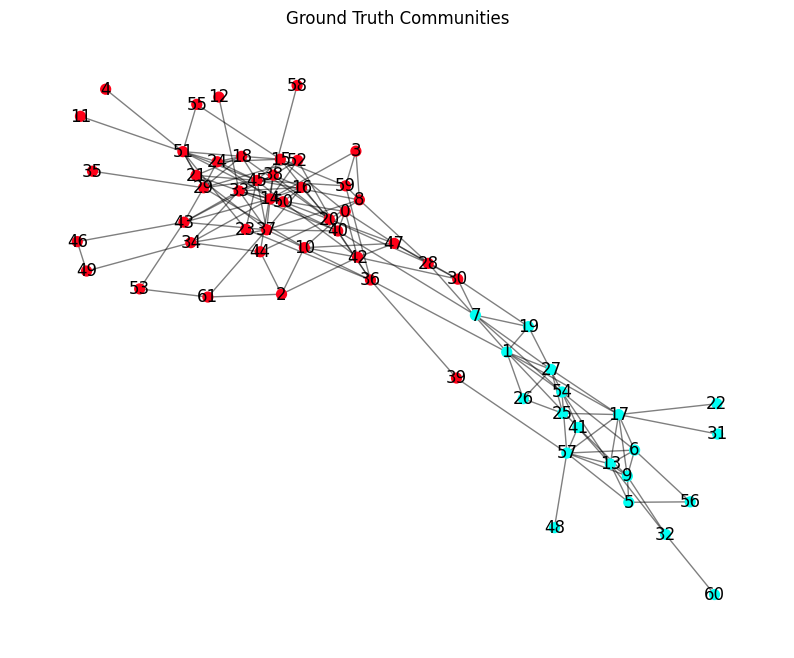

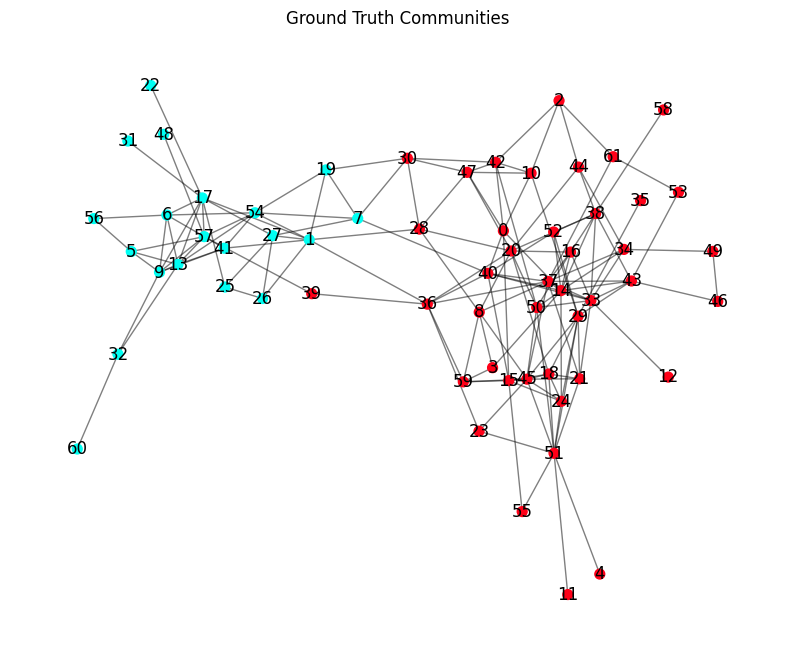

<ipython-input-3-c8108725ed90>:352: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', len(communities)+1)


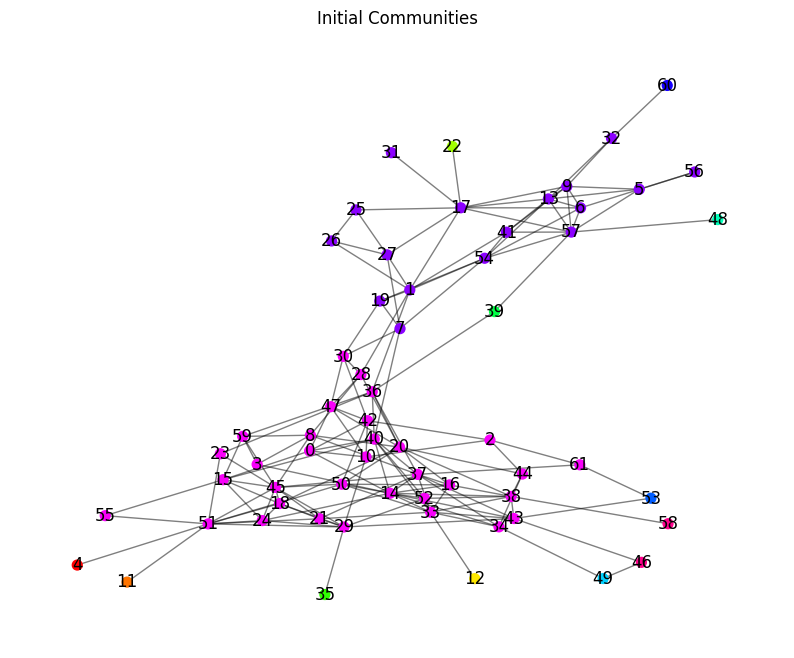

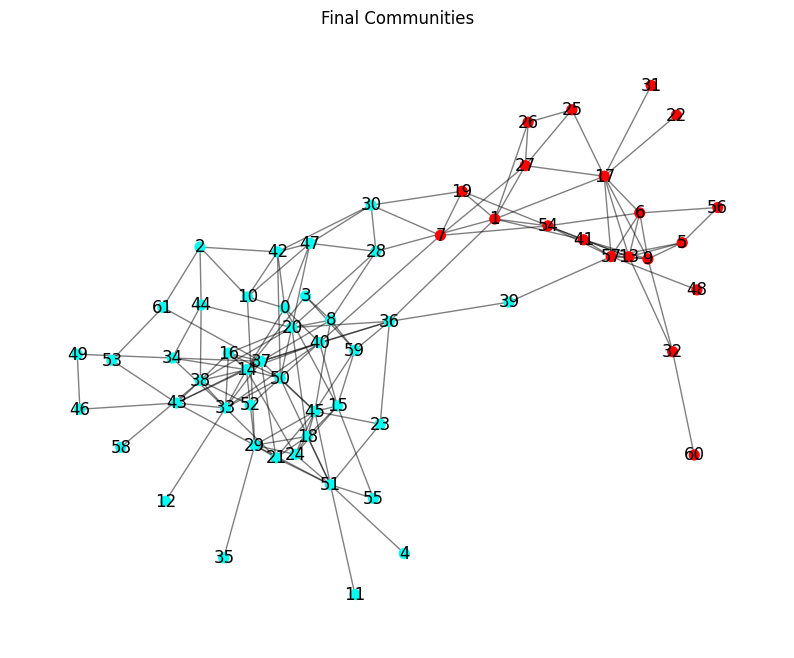

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law vs Exponential: R = -8.136808690495643, p = 0.03289603198448429
Power-law vs Lognormal: R = -7.190708721306496, p = 0.01096574831805283


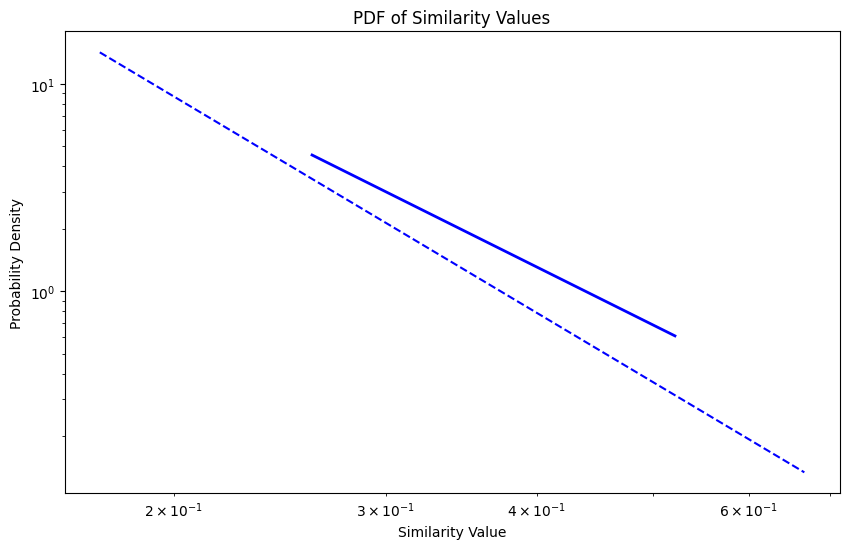

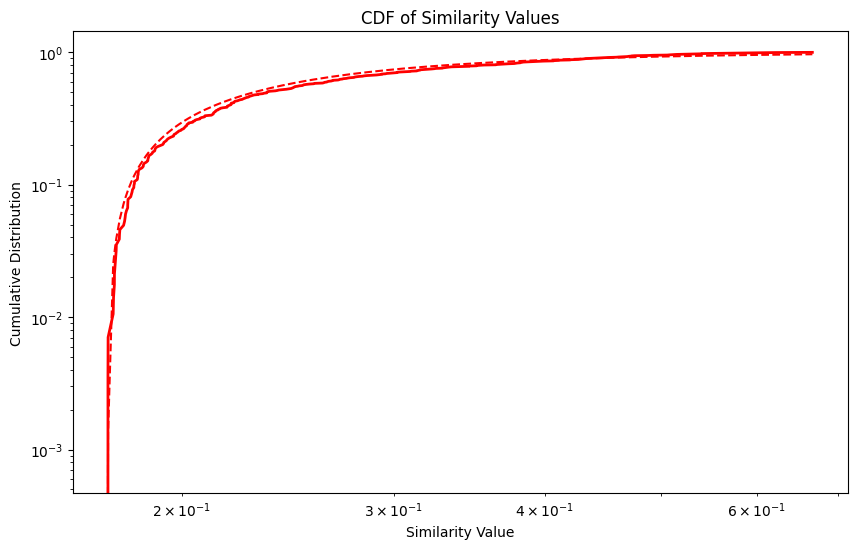

Power-law exponent (alpha): 3.468892976449622
Standard error in the fitted exponent (sigma): 0.146501845024702
Standard error in the fitted exponent (sigma): 0.146501845024702


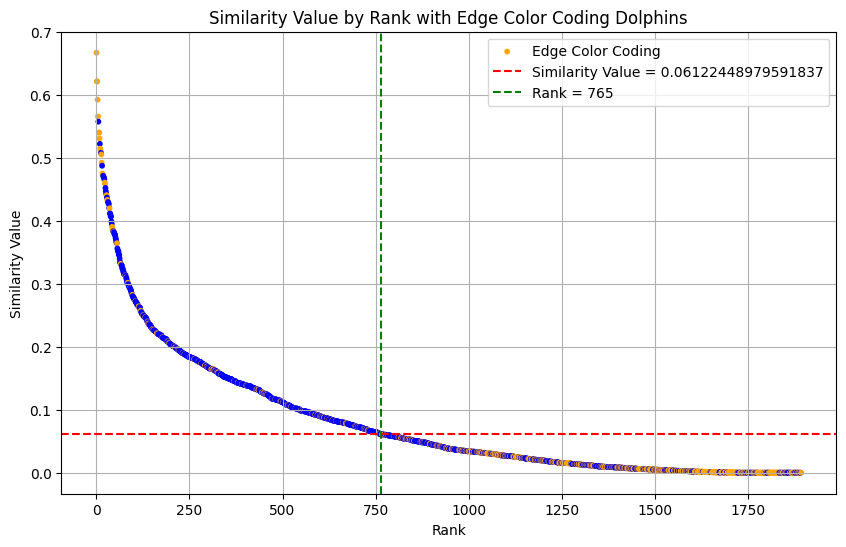

[(4, 51), (11, 51), (32, 60), (46, 49), (53, 61)]
Percentage of edges in G that are also in edges_in_G: 3.14%


In [ ]:
!pip install powerlaw
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
import urllib.request
import io
import zipfile
import copy
import powerlaw

def merge_small_communities(G, initial_communities, lambda_threshold=3):
    # Step 1: Classify communities based on size
    small_communities = [set(c) for c in initial_communities if len(c) < lambda_threshold]
    large_communities = [set(c) for c in initial_communities if len(c) >= lambda_threshold]

    # Initialize a list to store nodes from small communities without neighbors in large communities
    unassigned_nodes = []

    # For each small community, find the best large community to merge into
    for small_community in small_communities:
        best_total_similarity = 0
        best_large_community_index = None

        # Calculate total similarity of each small community node with nodes in each large community
        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for node in small_community:
                has_neighbor_in_large_community = any(neighbor in large_community for neighbor in G.neighbors(node))
                if has_neighbor_in_large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    for neighbor in G.neighbors(node):
                        if neighbor in large_community:
                            n_v = set(G.neighbors(neighbor)) | {neighbor}
                            intersection = len(n_u & n_v)
                            union = len(n_u | n_v)
                            similarity = float(intersection) / union if union != 0 else 0
                            total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # If no neighbors in large community, add the node to unassigned list
        if best_large_community_index is None:
            unassigned_nodes.extend(small_community)
        else:
            # Merge the small community into the best matching large community
            large_communities[best_large_community_index] = large_communities[best_large_community_index].union(small_community)

    # Reevaluate unassigned nodes with updated large communities
    for node in unassigned_nodes:
        best_total_similarity = 0
        best_large_community_index = None

        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for neighbor in G.neighbors(node):
                if neighbor in large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    n_v = set(G.neighbors(neighbor)) | {neighbor}
                    intersection = len(n_u & n_v)
                    union = len(n_u | n_v)
                    similarity = float(intersection) / union if union != 0 else 0
                    total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # Merge the unassigned node into the best matching large community
        if best_large_community_index is not None:
            large_communities[best_large_community_index].add(node)

    # Combine all communities after merging
    final_communities = large_communities + [list(c) for c in small_communities if len(c) >= lambda_threshold]

    return final_communities


def find_most_similar_node_pairs_iterative(similarity_matrix):
    current_similarity_matrix = copy.deepcopy(similarity_matrix)
    num_nodes = current_similarity_matrix.shape[0]

    # Initialize a dictionary to store results based on similarity values
    similar_pairs_dict = {}
    s = set()
    while (len(s) < num_nodes):
        # Find the indices of the maximum similarity value in the entire matrix
        i, j = np.unravel_index(np.argmax(current_similarity_matrix, axis=None), current_similarity_matrix.shape)
        similar_pair = (i, j)
        s.add(i)
        s.add(j)
        similar_value = current_similarity_matrix[i, j]

        # Exclude the current pair by setting its similarity to -inf
        current_similarity_matrix[i, j] = -np.inf

        # Append the result to the dictionary based on similarity value
        if similar_value not in similar_pairs_dict:
            similar_pairs_dict[similar_value] = []

        similar_pairs_dict[similar_value].append(similar_pair)

    # Print and return the results
    # for value, pairs in similar_pairs_dict.items():
    #     for idx, pair in enumerate(pairs):
    #          print(f"Similar Pair with Value {value}, Index {idx + 1}: {pair}")

    return similar_pairs_dict


def form_initial_communities(G, result_matrix, lambda_threshold=2, similarity_threshold=0.15):
    num_nodes = result_matrix.shape[0]
    communities = [[node] for node in range(num_nodes)]  # Initially, each node is in its own community
    edges_in_G = []  # List to hold edges present in G and set to zero
    edges_not_in_G = []  # List to hold edges not present in G and set to zero
    # Create a new similarity matrix with updated values
    updated_similarity_matrix = result_matrix.copy()
    zero_count = 0  # Counter for zero entries

    for i in range(num_nodes):
        for j in range(i+1,num_nodes):  # Consider upper triangular matrix to avoid repetition
            if result_matrix[i, j] < similarity_threshold:
                updated_similarity_matrix[i, j] = 0
                updated_similarity_matrix[j, i] = 0  # Symmetric update
                if G.has_edge(i, j) or G.has_edge(j, i):
                    edges_in_G.append((i, j))
                else:
                    edges_not_in_G.append((i, j))

    # Calculate the total number of node pairs
    # total_pairs = num_nodes * num_nodes
    # print(zero_count)

    # Calculate the percentage of node pairs assigned zero
    # zero_percentage = (zero_count / total_pairs) * 100

    # # Print the new similarity matrix
    # print("New Similarity Matrix:")
    # for row in updated_similarity_matrix:
    #     print(list(row))

    while True:
        # Find the pair of communities with the highest average similarity score
        max_avg_similarity = 0
        max_community_pair = None

        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                community_i = communities[i]
                community_j = communities[j]

                total_similarity = 0
                num_nodes_i = len(community_i)

                for u in community_i:
                    node_similarity_sum = sum(updated_similarity_matrix[u, v] for v in community_j)
                    node_avg_similarity = node_similarity_sum / len(community_j)
                    total_similarity += node_avg_similarity
                total_similarity /= num_nodes_i

                if total_similarity > max_avg_similarity:
                    max_avg_similarity = total_similarity
                    max_community_pair = (i, j)


        if max_community_pair is None:
            break  # No more communities to merge

        if max_avg_similarity < similarity_threshold:
                    break
        # Merge the communities with the highest average similarity score
        i, j = max_community_pair
        merged_community = communities[i] + communities[j]
        communities.pop(j)
        communities.pop(i)
        communities.append(merged_community)
        # print(zero_percentage)
        # Check if all remaining communities have at least the specified threshold
        if min(len(community) for community in communities) >= lambda_threshold:
            break



    return updated_similarity_matrix, edges_in_G, edges_not_in_G,communities

def matrix_operation(A, S, G):  # Assuming G is your graph
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    n = num_edges / num_nodes  # Calculate n as the number of nodes divided by the number of edges

    # Calculate S^n
    S_power_n = np.linalg.matrix_power(S, int(n))

    # Perform A * S^n
    result = np.dot(A, S_power_n)

    return result


def normalized_coefficients(jaccard_matrix):
    # Initialize an empty matrix of the same shape as the jaccard_matrix
    normalized_matrix = np.zeros(jaccard_matrix.shape)

    # Iterate over each row in the jaccard_matrix
    for i in range(jaccard_matrix.shape[0]):
        row_sum = np.sum(jaccard_matrix[i, :])  # Calculate the sum of the current row
        if row_sum > 0:  # Avoid division by zero
            normalized_matrix[i, :] = jaccard_matrix[i, :] / row_sum
            nsum = np.sum(normalized_matrix[i, :])  # Normalize the row by its sum
    # checks if the sum of each row is 1
    # for i in range(normalized_matrix.shape[0]):
    #     row_sum = np.sum(normalized_matrix[i, :])
    #     print(f"Sum of row {i}: {row_sum}")
    print(normalized_matrix)
    return normalized_matrix


def get_jaccard_coefficients(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v:  # Ensure we're not comparing a node with itself
                n_u = set(G[u])  # Neighbors of u
                n_v = set(G[v])  # Neighbors of v
                intersection = len(n_u & n_v)
                union = len(n_u | n_v)/2
                adjacency_matrix[u, v] = float(intersection) / (union) if intersection != 0 else 0

    return adjacency_matrix


def get_adjacency_matrix(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if G.has_edge(i, j):
                adjacency_matrix[i, j] = 1
            else:
                adjacency_matrix[i, j] = 0

    return adjacency_matrix


url = "https://websites.umich.edu/~mejn/netdata/dolphins.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("dolphins.txt").decode()  # read info file
gml = zf.read("dolphins.gml").decode()
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
mapping = dict(zip(G.nodes(), range(len(G.nodes()))))
G = nx.relabel_nodes(G, mapping)

# gt_membership = [G.nodes[v]['club'] for v in G.nodes()]
dolphin_groundtruth=[2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2]
Adjancency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)
# print(A)
# print(jaccard_coefficients)
# print(jaccard_normalized)
# Optionally, print the Jaccard coefficients
markov_similarity_enhancement_matrix = matrix_operation(Adjancency, jaccard_normalized, G)
# print(markov_similarity_enhancement_matrix)
most_similar_pairs = find_most_similar_node_pairs_iterative(markov_similarity_enhancement_matrix)
updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.05714285714285715)
# initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.2)
print(initial_communities)


final_communities = merge_small_communities(G, initial_communities,lambda_threshold=3)


print("----------------------------Initial Community----------------------------------")
for i, community in enumerate(initial_communities):
    print(f"Community {i + 1}: {community}")

print("-----------------------------Final Community-----------------------------------")
for i, community in enumerate(final_communities):
    print(f"Final Community {i + 1}: {community}")


def create_sets_based_on_membership(G, dolphin_groundtruth):
    membership_sets = {}  # Dictionary to store sets of nodes for each ground truth membership

    for node, membership in enumerate(dolphin_groundtruth):
        if membership not in membership_sets:
            membership_sets[membership] = set()

        membership_sets[membership].add(node)

    return membership_sets
membership_sets = create_sets_based_on_membership(G, dolphin_groundtruth)
print("------------------------Sets based on Ground Truth Membership-------------------")
for membership, node_set in membership_sets.items():
    print(f"Ground Truth Membership: {membership}, Nodes: {node_set}")

print("Modularity",nx.community.quality.modularity(G, final_communities))

num_nodes = G.number_of_nodes()

predicted_labels = np.zeros(num_nodes, dtype=int)
for idx, community in enumerate(final_communities):
    for node in community:
        predicted_labels[node] = idx+1
print("Predicted Labels:", predicted_labels)
nmi_score_binary_matrix = normalized_mutual_info_score(dolphin_groundtruth, predicted_labels)

print("NMI Score", nmi_score_binary_matrix)


def plot_groundtruth_communities(G, membership_sets):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(membership_sets)+1)

    # Assign a color to each ground truth membership
    membership_colors = {node: color_map(membership) for membership, nodes in membership_sets.items() for node in nodes}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[membership_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title("Ground Truth Communities")
    plt.axis('off')
    plt.show()

plot_groundtruth_communities(G, membership_sets)

def plot_communities(G, communities, title):
    # Generate a color palette
    color_map = plt.cm.get_cmap('hsv', len(communities)+1)

    # Assign a color to each community
    community_colors = {node: color_map(i) for i, community in enumerate(communities) for node in community}

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[community_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
# Plot the initial communities
plot_groundtruth_communities(G, membership_sets)
plot_communities(G, initial_communities, "Initial Communities")

# Plot the final communities
plot_communities(G, final_communities, "Final Communities")


# similarity_thresholds = np.linspace(0, 0.1, 50)  # Adjust range and steps as needed
# modularity_values = []
# nmi_values = []

# Adjacency = get_adjacency_matrix(G)
# jaccard_coefficients = get_jaccard_coefficients(G)
# jaccard_normalized = normalized_coefficients(jaccard_coefficients)

# # Iterate over similarity thresholds
# for similarity_threshold in similarity_thresholds:
#     # Enhance similarity matrix and find communities

#     markov_similarity_enhancement_matrix = matrix_operation(Adjacency, jaccard_normalized, G)
#     updated_similarity_matrix, edges_in_G, edges_not_in_G, initial_communities = form_initial_communities(G, markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=similarity_threshold)
#     final_communities = merge_small_communities(G, initial_communities, lambda_threshold=3)

#     # Calculate modularity
#     modularity = nx.community.quality.modularity(G, final_communities)
#     modularity_values.append(modularity)

#     # Calculate NMI
#     predicted_labels = np.zeros(G.number_of_nodes(), dtype=int)
#     for idx, community in enumerate(final_communities):
#         for node in community:
#             predicted_labels[node] = idx
#     nmi = normalized_mutual_info_score(dolphin_groundtruth , predicted_labels)
#     nmi_values.append(nmi)

# max_modularity_index = np.argmax(modularity_values)
# max_nmi_index = np.argmax(nmi_values)

# # Corresponding similarity thresholds
# similarity_threshold_with_max_modularity = similarity_thresholds[max_modularity_index]
# similarity_threshold_with_max_nmi = similarity_thresholds[max_nmi_index]

# # Maximum modularity and NMI values
# max_modularity = modularity_values[max_modularity_index]
# max_nmi = nmi_values[max_nmi_index]

# print("Maximum Modularity:")
# print("Similarity Threshold:", similarity_threshold_with_max_modularity)
# print("Modularity:", max_modularity)

# print("\nMaximum NMI:")
# print("Similarity Threshold:", similarity_threshold_with_max_nmi)
# print("NMI:", max_nmi)

# # Plot both Modularity and NMI values against similarity thresholds
# plt.plot(similarity_thresholds, modularity_values, label='Modularity')
# plt.plot(similarity_thresholds, nmi_values, label='NMI')
# plt.title('Modularity and NMI vs Similarity Threshold')
# plt.xlabel('Similarity Threshold')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

def analyze_similarity_distribution(similarities):
    # Fit the similarity values to a power-law distribution
    fit = powerlaw.Fit(similarities)

    # Compare the power-law distribution with an exponential distribution
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    # Compare the power-law distribution with a lognormal distribution
    R_lognorm, p_lognorm = fit.distribution_compare('power_law', 'lognormal')

    # Print the comparison results
    print(f"Power-law vs Exponential: R = {R_exp}, p = {p_exp}")
    print(f"Power-law vs Lognormal: R = {R_lognorm}, p = {p_lognorm}")

    # Plot the PDF and CDF
    plt.figure(figsize=(10, 6))
    figPDF = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=figPDF)
    plt.xlabel('Similarity Value')
    plt.ylabel('Probability Density')
    plt.title('PDF of Similarity Values')

    plt.figure(figsize=(10, 6))
    figCDF = fit.plot_cdf(color='r', linewidth=2)
    fit.power_law.plot_cdf(color='r', linestyle='--', ax=figCDF)
    plt.xlabel('Similarity Value')
    plt.ylabel('Cumulative Distribution')
    plt.title('CDF of Similarity Values')
    plt.show()

    # Get the parameters of the power law fit
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    print(f"Power-law exponent (alpha): {alpha}")
    print(f"Standard error in the fitted exponent (sigma): {sigma}")

    print(f"Standard error in the fitted exponent (sigma): {sigma}")

def plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    i_upper = np.triu_indices_from(markov_similarity_enhancement_matrix, k=1)
    similarities = markov_similarity_enhancement_matrix[i_upper]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]
    analyze_similarity_distribution(sorted_similarities)
    # Prepare color array
    colors = []
    for idx in range(len(sorted_indices)):
        i, j = np.unravel_index(i_upper[0][sorted_indices[idx]], markov_similarity_enhancement_matrix.shape)
        if (i, j) in edges_in_G or (j, i) in edges_in_G:
            colors.append('red')
        elif (i, j) in edges_not_in_G or (j, i) in edges_not_in_G:
            colors.append('orange')
        else:
            colors.append('blue')

    # Find the rank of the specified similarity value or the closest to it
    rank = np.searchsorted(sorted_similarities[::-1], similarity_value, side='left')
    # Adjust rank for 1-based indexing and for plotting (since we're using the sorted array in descending order)
    rank_adjusted = len(sorted_similarities) - rank

    ranks = np.arange(1, len(sorted_similarities) + 1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(ranks, sorted_similarities, c=colors, s=10, label='Edge Color Coding')
    plt.axhline(y=similarity_value, color='r', linestyle='--', label=f'Similarity Value = {similarity_value}')
    plt.axvline(x=rank_adjusted, color='g', linestyle='--', label=f'Rank = {rank_adjusted}')
    plt.xlabel('Rank')
    plt.ylabel('Similarity Value')
    plt.title('Similarity Value by Rank with Edge Color Coding Dolphins')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage, assuming markov_similarity_enhancement_matrix, G, edges_in_G, and edges_not_in_G are already defined
similarity_value = 0.06122448979591837  # Example similarity value
plot_similarity_rank(markov_similarity_enhancement_matrix, G, edges_in_G, edges_not_in_G, similarity_value)
print(edges_in_G)
def calculate_percentage_of_edges_in_G(G, edges_in_G):
    # Count the total number of edges in G
    total_edges_in_G = G.number_of_edges()

    # Count how many edges in the list are actually in G
    # Note: This step might be redundant if edges_in_G only contains edges from G,
    # but it's a safeguard in case edges_in_G contains more than that.
    edges_in_G_count = len(edges_in_G)

    # Calculate the percentage
    percentage = (edges_in_G_count / total_edges_in_G) * 100

    return percentage

# Assuming G and edges_in_G are already defined
percentage_of_edges_in_G = calculate_percentage_of_edges_in_G(G, edges_in_G)
print(f"Percentage of edges in G that are also in edges_in_G: {percentage_of_edges_in_G:.2f}%")
